# 24-Hour Load Forecasting

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
import datetime
import mpld3

mpld3.enable_notebook()
%matplotlib inline

load = pd.read_csv('data/load/NCENT.csv')
weather = pd.read_csv('data/weather/NCENT.csv')
load.head()

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,10336.304899,8894.325899,7124.208773,7312.259820,7549.809438,10278.440568,10782.487804,10329.687507,12405.849409,10038.701857,8648.989316,10370.322921,12298.801147,13640.024978,11409.339036,9239.153285,18584.343617
1,10178.052738,8903.379971,6854.581504,7012.466197,7291.494704,10254.628659,10873.001190,10284.115785,12485.814858,9982.845460,8553.212708,10153.942806,12297.109823,13425.121941,11235.174936,9104.997245,18524.141392
2,10100.887710,8956.825659,6639.484787,6712.807281,7012.269706,10282.656844,10952.637481,10238.594551,12559.461123,9870.152864,8461.317967,9989.243532,12285.295247,13286.070909,11151.965219,8988.035201,18532.056616
3,10081.565109,9051.877218,6492.392024,6502.378446,6896.466664,10379.404402,11104.178758,10315.930645,12671.847950,9962.356063,8438.693857,9947.855512,12368.070073,13310.892590,11209.701072,8979.148462,18647.444612
4,10192.218670,9261.293160,6452.262173,6440.559639,6810.395549,10569.074587,11369.935036,10521.472154,12912.267303,10157.366636,8565.433348,10097.444234,12639.017359,13423.345503,11428.716965,9033.547636,19002.102222


## First get everything into one large dataframe
load | dt, day of week, hour of day, years since 2000, temperature

In [33]:
large_df = pd.DataFrame()
l, t = [], []
for column in load.columns:
    l.append(list(load[column]))
    t.append(list(weather[column]))
# flatten
lf = [i for s in l for i in s]
tf = [i for s in t for i in s]

large_df['load'] = lf
large_df['tempc'] = tf

# fix outliers
large_df['tempc'].replace([-9999], np.nan, inplace=True)
large_df['tempc'].ffill(inplace=True)
large_df['load'].ffill(inplace=True)

large_df['load_prev'] = large_df['load'].shift(24)
large_df['load_prev'].bfill(inplace=True)

d = []
for i in range(2002, 2019):
    d.append([(dt(i, 1, 1) + timedelta(hours=1)*x) for x in range(8760)]) 
large_df['dates'] = [i for s in d for i in s]

large_df['day'] = large_df['dates'].dt.dayofweek # 0 is MONDAY!!!
large_df['hour'] = large_df['dates'].dt.hour
large_df['month'] = large_df['dates'].dt.month
large_df['year'] = large_df['dates'].dt.year
large_df.head()
#large_df.to_csv('flatData.csv', index=False)

,load,tempc,load_prev,dates,day,hour,month,year
0,10336.304899,1.7,10336.304899,2002-01-01 00:00:00,1,0,1,2002
1,10178.052738,1.7,10336.304899,2002-01-01 01:00:00,1,1,1,2002
2,10100.887710,1.1,10336.304899,2002-01-01 02:00:00,1,2,1,2002
3,10081.565109,0.6,10336.304899,2002-01-01 03:00:00,1,3,1,2002
4,10192.218670,0.6,10336.304899,2002-01-01 04:00:00,1,4,1,2002


### Normalize the data from \[-1, 1\]

In [34]:
norm_df = large_df.drop(['dates'], axis=1)

norm_df['yearSince2000'] = norm_df['year'] - 2000
norm_df['years_n'] = (norm_df['yearSince2000'] - norm_df['yearSince2000'].mean()) / (norm_df['yearSince2000'].max() - norm_df['yearSince2000'].min())

norm_df['load_prev_n'] = (norm_df['load_prev'] - norm_df['load_prev'].mean()) / (norm_df['load_prev'].max() - norm_df['load_prev'].min())
norm_df['temp_n'] = (norm_df['tempc'] - norm_df['tempc'].mean()) / (norm_df['tempc'].max() - norm_df['tempc'].min())

norm_df.drop(['load', 'tempc', 'year'], axis=1, inplace=True)

norm_df['day'] += 1 # make Sunday 0
norm_df.loc[norm_df['day'] == 7, 'day'] = 0


### Let's now turn into a binary dataframe

In [52]:
bin_df = pd.DataFrame()
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    s = []
    for i in range(0, len(l), n):
         s.append(l[i:i + n])
    return [l[i:i+n] for i in range(0, len(l), n)]

l = list(large_df['load'])
m = [i for i in chunks(l, 24)]
s = [val for val in m for _ in range(24)]
n = np.array(s)

for i in range(24):
    s = 'l' + str(i)
    bin_df[s] = n[:, i]
    bin_df[s] = (bin_df[s] - large_df['load'].mean()) / (large_df['load'].max() - large_df['load'].min())

bin_df.head()

# create month vector
y = [('m' + str(i)) for i in range(12)]
for i, m in enumerate(y):
    bin_df[m] = (norm_df['month'] == i).astype(int)

# create day of week vector
w = ['S', 'M', 'T', 'W', 'R', 'F', 'A']
for i, d in enumerate(w):
    bin_df[d] = (norm_df['day'] == i).astype(int)

# create hour of day vector
d = [('h' + str(i)) for i in range(24)]
for i, h in enumerate(d):
    bin_df[h] = (norm_df['hour'] == i).astype(int)

bin_df['years_n'] = norm_df['years_n']
bin_df['temp_n'] = norm_df['temp_n']
bin_df['load_prev_n'] = norm_df['load_prev_n']

# holidays
m = {'Christmas Day (Observed)': [
		datetime.date(1993, 12, 24),
		datetime.date(1994, 12, 26),
		datetime.date(1999, 12, 24),
		datetime.date(2004, 12, 24),
		datetime.date(2005, 12, 26),
		datetime.date(2010, 12, 24),
		datetime.date(2011, 12, 26),
		datetime.date(2016, 12, 26),
		datetime.date(2021, 12, 24),
		datetime.date(2022, 12, 26),
	]
}
m1 = ((large_df['month'] == 12) & (large_df['dates'].dt.day == 25))
m2 = large_df['dates'].dt.date.isin(m['Christmas Day (Observed)'])
bin_df['isChristmas'] = m1| m2
print(bin_df[bin_df['isChristmas']].shape)
bin_df[bin_df['isChristmas']]

(528, 71)


,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,h18,h19,h20,h21,h22,h23,years_n,temp_n,load_prev_n,isChristmas
8592,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.347319,-0.134647,True
8593,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.356680,-0.143721,True
8594,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.367914,-0.144520,True
8595,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.379148,-0.141534,True
8596,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.388510,-0.131992,True
8597,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.409105,-0.098930,True
8598,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.420339,-0.057719,True
8599,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.429700,-0.011164,True
8600,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.429700,0.028740,True
8601,-0.053919,-0.059062,-0.057586,-0.052496,-0.042093,-0.022481,0.000988,0.026468,0.030594,0.006326,...,0,0,0,0,0,0,-0.5000,-0.429700,0.054162,True


In [36]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

all_X = bin_df#.drop('load_prev_n', axis=1) # all rows, features only, no labels
all_y = large_df['load'] #all rows, label only, no features

X_train, y_train = all_X[:-8760], all_y[:-8760]

In [37]:
clf = linear_model.SGDRegressor(max_iter=10000, tol=1e-4)
clf.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=10000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

0.9268321901927743
0.9191403870563802


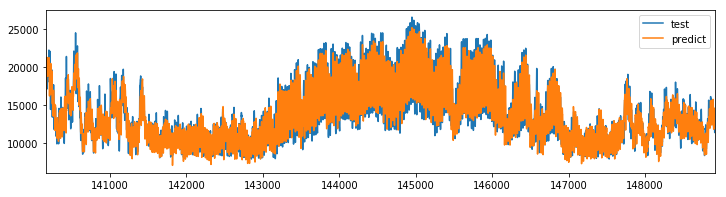

In [38]:
X_test, y_test = all_X[-8760:], all_y[-8760:]
y_prediction = clf.predict(X_test)

graph_df = pd.DataFrame()
graph_df['test'] = y_test
graph_df['predict'] = y_prediction
graph_df.plot(figsize=(12, 3))

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

In [39]:
large_df.groupby('month')['load'].quantile(.99)

month
1     19572.431368
2     19104.158817
3     15424.819489
4     15130.380366
5     18784.576985
6     22244.625611
7     23526.930544
8     23935.375433
9     21721.757333
10    18045.548184
11    15731.079089
12    17793.018964
Name: load, dtype: float64

In [40]:
large_df.columns

Index(['load', 'tempc', 'load_prev', 'dates', 'day', 'hour', 'month', 'year'], dtype='object')

In [41]:
m = []
large_df['dayOfYear'] = large_df['dates'].dt.dayofyear
for month in range(1, 13):
    test = large_df[large_df['month'] == month]
    m.append(test.loc[test['load'].idxmax()]['dayOfYear'])

In [42]:
print(m)

[17, 37, 62, 107, 150, 178, 200, 215, 251, 282, 318, 354]
